## The goal of this notebook is to conduct sentiment analysis and generate animated charts of sentiment as one progresses through the book

In [ ]:
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import os
import glob
import re
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
from matplotlib import animation as ani
import numpy as np
import pickle
import json

In [2]:
%matplotlib notebook

In [3]:
files = glob.glob("C:/Users/aiden/Dropbox/BOOKS/Malazan Series/SE/Steven Erikson - Malazan Book of the Fallen 10 Books/ePub/*epub")

In this Notebook, I rely on the index number of the book to maintain flow, and here I initialize an idx to full name mapping for graphical purposes later

In [20]:
books_idx_to_name = {}
for f in files:
    f = os.path.basename(f)
    idx = re.search('\d+', f).group(0)
    name = re.search("(?<=- ).*(?=-)", f).group(0)
    books_idx_to_name[idx] = name

In [ ]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [ ]:
blacklist = [   '[document]', 'noscript', 'header', 'html', 'meta', 'head','input', 'script']
sect_blacklist = ['toc', 'AbouttheAuthor', 'TitlePage', 'CopyrightPage', 'Dedication', '_cover']


To begin, I built the dictionary I will use containing all the relevant information

I utilize TextBlob's sentiment analysis feature to generate polarity scores, which take the range from [-1, 1], where a negative value indicates negative sentiment and positive value indicates positive sentiment.

Sources:  
[1] https://planspace.org/20150607-textblob_sentiment/  
[2] https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.sentiment

In [ ]:
begin_flags = ['prologue', 'dust_of_dreams_split_012', 'id152', 'deadhouse_gates_013_chapter03.html', 'midnight_tides_014_chapter03.html']
end_flags = ['epilogue', 'dust_of_dreams_split_048', 'id13$', 'deadhouse_gates_042_part05.html', 'midnight_tides_044_epilogue.html']
def process_book(f):
    book = epub.read_epub(f)
    chapters = {}
    log = False
    ## Read in book to individual chapters
    for item in book.get_items():
        if any([x in item.get_id().lower() for x in begin_flags]):
            log = True
        if log:
            chap_id = re.search("\d{3}|\d{2}", item.get_id()).group(0)
            soup = BeautifulSoup(item.get_content(), 'html5lib')
            txt = soup.find_all(text=True)
            tmp = [t for t in txt if t.parent.name not in blacklist]
            chapters[chap_id] = {
                "text" : tmp,
                "type" : item.get_type(),
                "id" : item.get_id() 
            }
        if re.search('|'.join(end_flags), item.get_id().lower()) is not None:
            log = False
    ## For each chapter, generate sentiment
    ## Tokenize each sentence and generate polarity score
    ## TextBlob documentation: https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis
    for ch in chapters:
        sentences = sent_tokenize(re.sub('[\r\n]', '', ' '.join(chapters[ch]['text'])))
        chapters[ch]['sentiment'] = [TextBlob(s).sentiment.polarity for s in sentences]
        chapters[ch]['cum_sentiment'] = np.cumsum(chapters[ch]['sentiment'])
    return chapters

In [ ]:
book_meta = {}
for f in files:
    book_base = os.path.basename(f).replace('.epub', '')
    book_id = re.search('\d+', book_base).group(0)
    print(f"Processing {book_base}")
    book_meta[book_id] = process_book(f)
    book_meta[book_id]["book_name"] = re.search("(?<=\- ).*", book_base).group(0)
    print(f"Finished processing {book_meta[book_id]['book_name']}")

Next, I save a copy of the processed to load it in next time

In [ ]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

In [ ]:
## Write to disk
with open("C:/Users/aiden/Dropbox/git/malazan_nlp/data/books_meta.txt", 'w') as file:
     file.write(json.dumps(book_meta, cls=NumpyEncoder))

In [21]:
## To load it back in
with open("C:/Users/aiden/Dropbox/git/malazan_nlp/data/books_meta.txt") as jsonfile:
    book_meta = json.load(jsonfile)
# books_meta = json.load("C:/Users/aiden/Dropbox/git/malazan_nlp/data/books_meta.txt")

## Average sentiment by chapter

In [22]:
def pad_array(x, l, r):
    """ This function is intended to pad an array left and right to the same length
    """
    r_pad = max_len - r
    return np.pad(x, (l, r_pad), constant_values = (None, None))

In [43]:
mcolors.TABLEAU_COLORS

OrderedDict([('tab:blue', '#1f77b4'),
             ('tab:orange', '#ff7f0e'),
             ('tab:green', '#2ca02c'),
             ('tab:red', '#d62728'),
             ('tab:purple', '#9467bd'),
             ('tab:brown', '#8c564b'),
             ('tab:pink', '#e377c2'),
             ('tab:gray', '#7f7f7f'),
             ('tab:olive', '#bcbd22'),
             ('tab:cyan', '#17becf')])

In [46]:
import matplotlib.colors as mcolors
colors = list(mcolors.XKCD_COLORS.keys())[0:10]

In [24]:
max_len = sum([len(book_meta[b]) - 1 for b in book_meta])
max_len  ## The number of chapters

344

In [25]:
## First we need to compile the data 
data = []
x = np.array(list(range(max_len)), dtype = np.float32)
x_beg = 0
for book in book_meta:
    y_sent = np.array([np.average(book_meta[book][c]['sentiment']) for c in book_meta[book].keys() if c != 'book_name'], dtype = np.float32)
    y_add = x_beg + len(y_sent)
    data.append([ pad_array(x[x_beg:y_add], x_beg, y_add), 
                 pad_array(y_sent, x_beg, y_add), 
                 book])
    x_beg = y_add

Padding sents len 33 adding 0 to left and 311 to right total of 344
Padding sents len 0 adding 33 to left and 281 to right total of 344
Padding sents len 0 adding 63 to left and 244 to right total of 344
Padding sents len 0 adding 100 to left and 212 to right total of 344
Padding sents len 0 adding 132 to left and 181 to right total of 344
Padding sents len 0 adding 163 to left and 147 to right total of 344
Padding sents len 0 adding 197 to left and 117 to right total of 344
Padding sents len 0 adding 227 to left and 87 to right total of 344
Padding sents len 0 adding 257 to left and 50 to right total of 344
Padding sents len 0 adding 294 to left and 0 to right total of 344


<IPython.core.display.Javascript object>


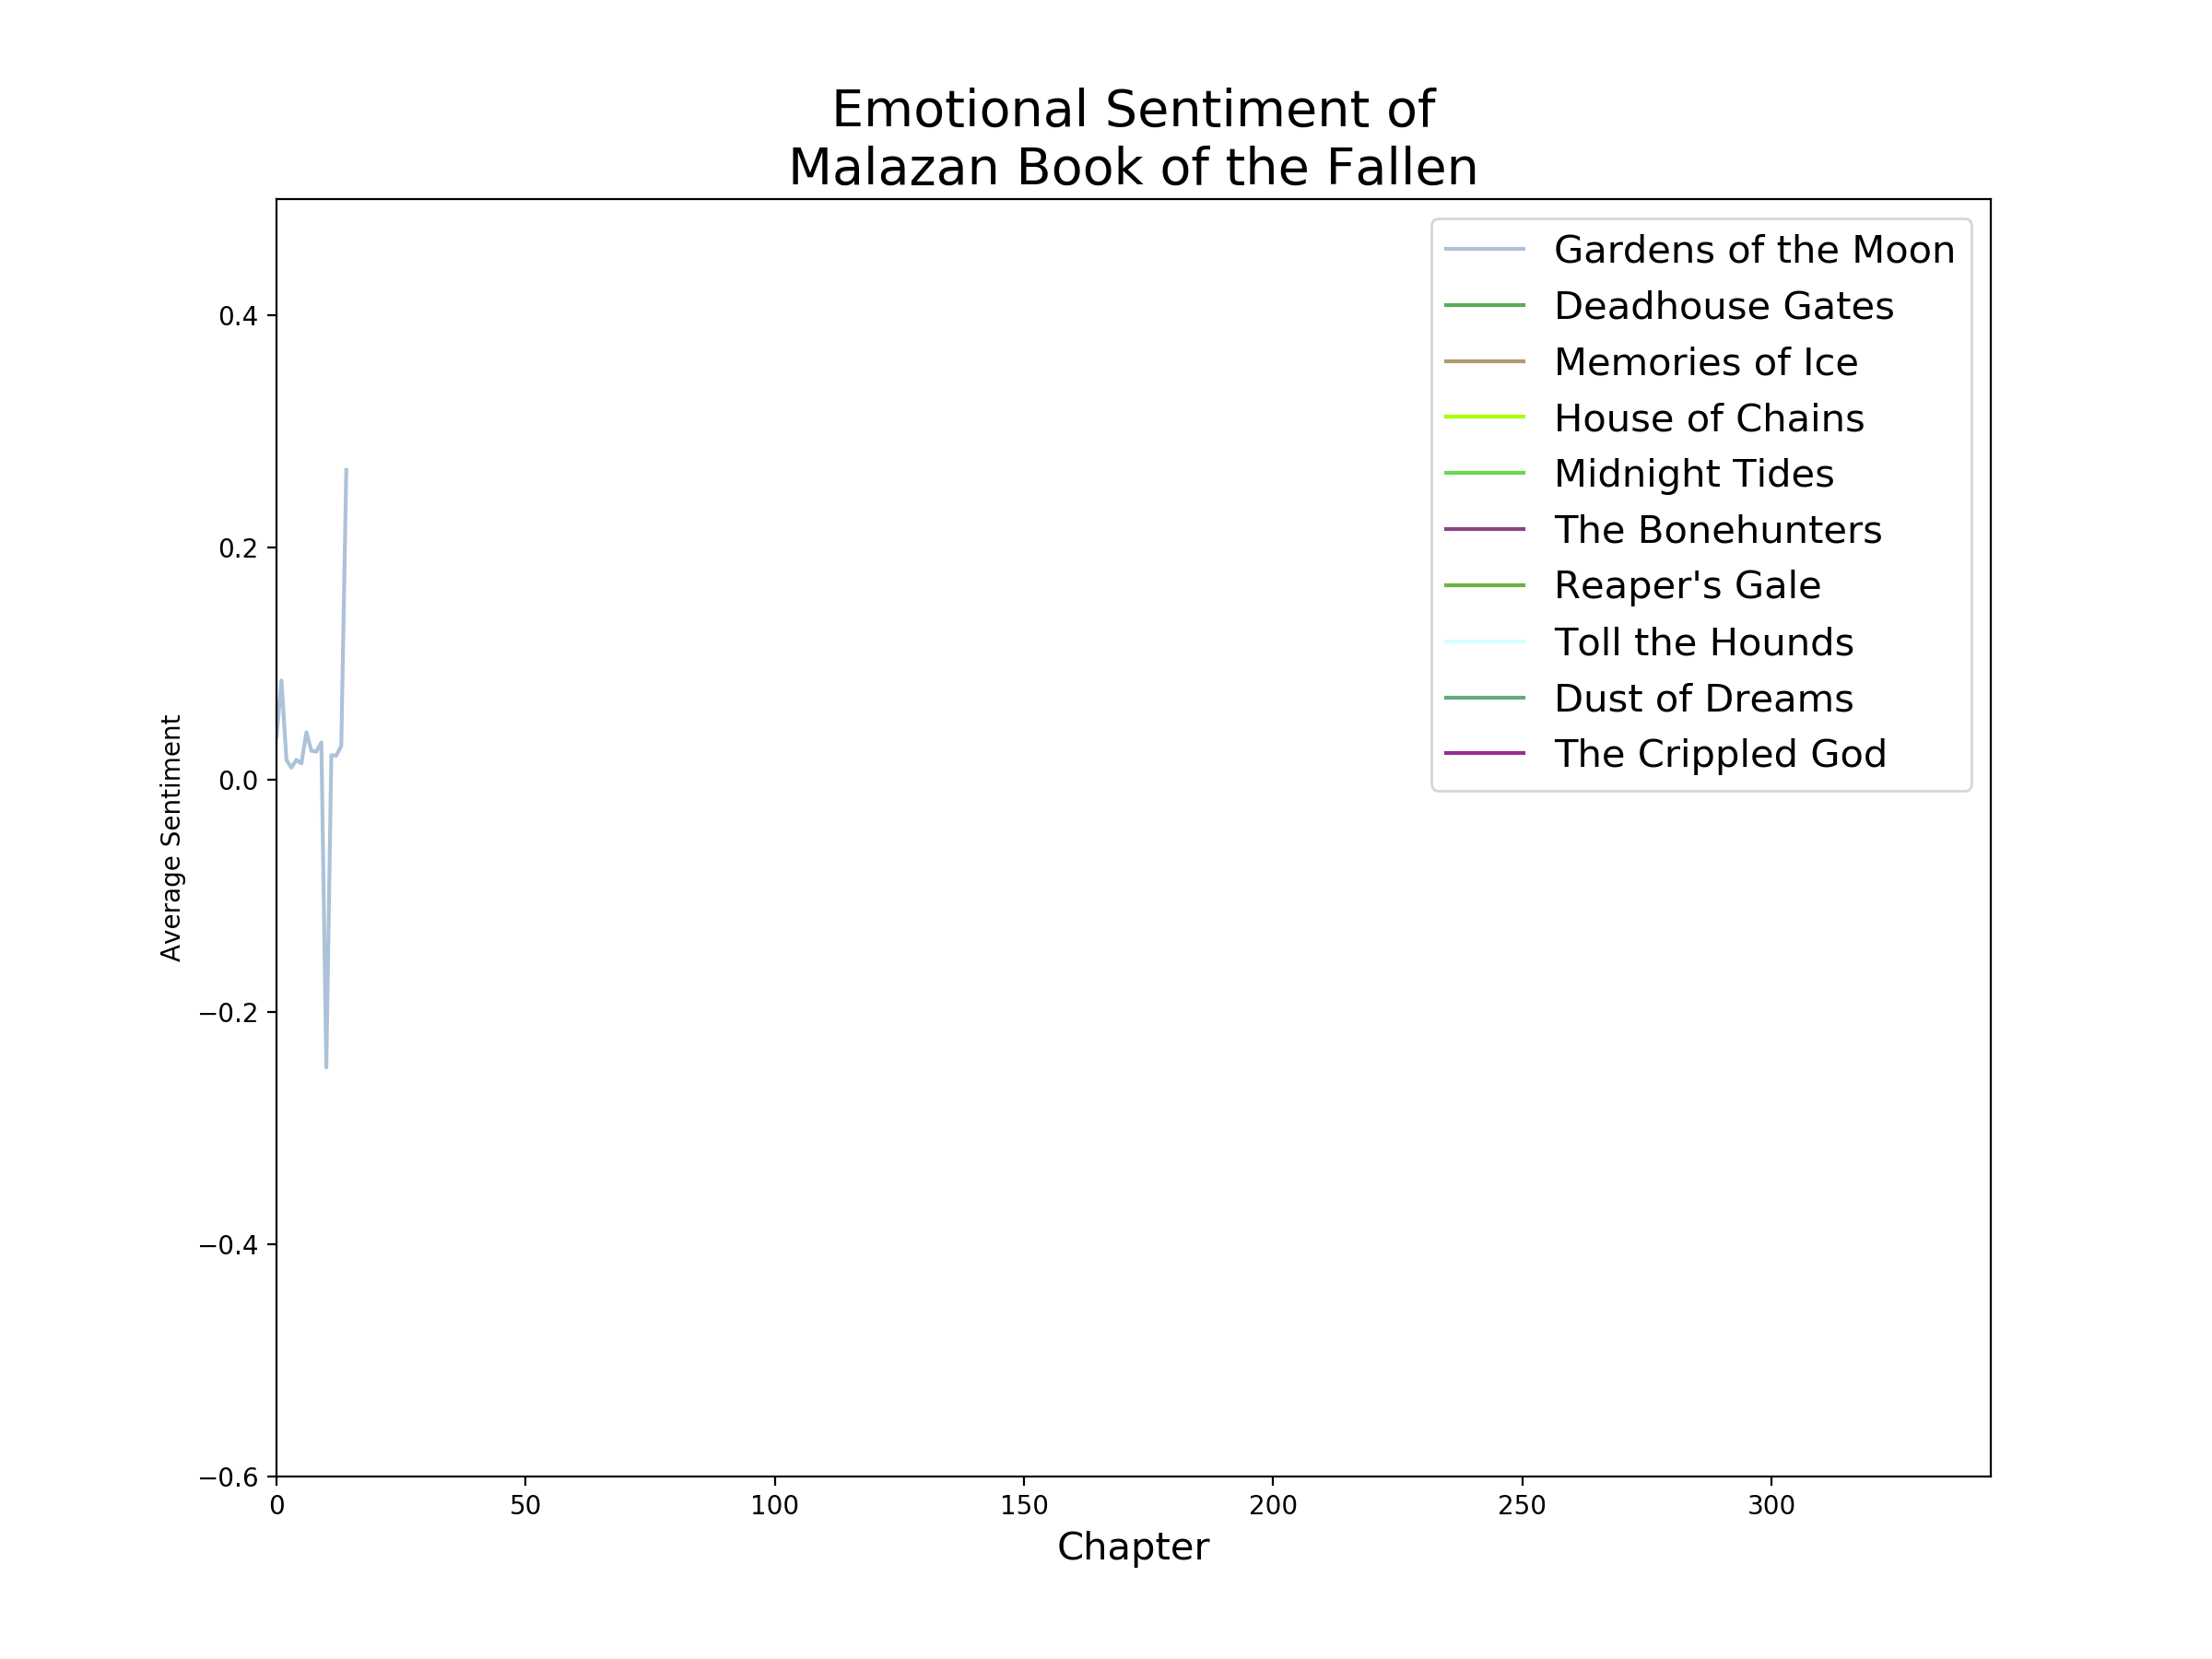

In [47]:
## Animate above plot!
N = len(data)

fig = plt.figure(figsize=(12, 9))
ax = plt.axes(xlim=(0,max_len), ylim=(-0.6, 0.5))

lines = [plt.plot([], [])[0] for _ in range(N)]

def update(num):
    for j in range(N):
        lines[j].set_data(data[j][0][:num], data[j][1][:num] )
        lines[j].set_color(mcolors.XKCD_COLORS[colors[j]])
        lines[j].set_label(books_idx_to_name[data[j][2]].strip())
        plt.legend(loc='best', fontsize=15)
    return lines,

anim = ani.FuncAnimation(fig, update, 500, interval=200, blit=True)

plt.title('Emotional Sentiment of\nMalazan Book of the Fallen', fontsize=20)
plt.xlabel('Chapter', fontsize=15)
plt.ylabel('Average Sentiment', fontsize=10)

anim.save('malazan_ch_sentiments.mp4', fps=60, extra_args=['-vcodec', 'libx264'])

plt.show()